In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb

In [30]:
dataset = pd.read_csv('diabetes.csv')
dataset

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [31]:
dataset.shape

(768, 9)

In [32]:
dataset.isna().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [33]:
dataset.drop_duplicates(inplace=True)

In [34]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [35]:
dataset.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [36]:
dataset['Outcome'].value_counts()

,count
Outcome,
0,500
1,268


In [37]:
dataset['Insulin'].nunique()

186

In [38]:
dataset['Insulin'].value_counts()

,count
Insulin,
0,374
105,11
130,9
140,9
120,8
...,...
178,1
127,1
510,1


In [39]:
X = dataset.drop(['Outcome'], axis = 1)
y = dataset['Outcome']

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay

def plot_confusion_roc(model_name, y_true, y_pred, y_proba=None):
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(6, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues', ax=ax, values_format='.0f')  # <- Force normal float format (no exponential)
    ax.set_title(f"{model_name} - Confusion Matrix", fontsize=14)
    plt.grid(False)
    plt.tight_layout()
    plt.savefig("Ensemble.png", dpi=300, bbox_inches="tight")
    plt.show()

    noisy_proba = y_pred

    # ROC Curve using noisy predictions
    fpr, tpr, _ = roc_curve(y_true, noisy_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess (Baseline)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve (based on noisy predictions)', fontsize=14)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

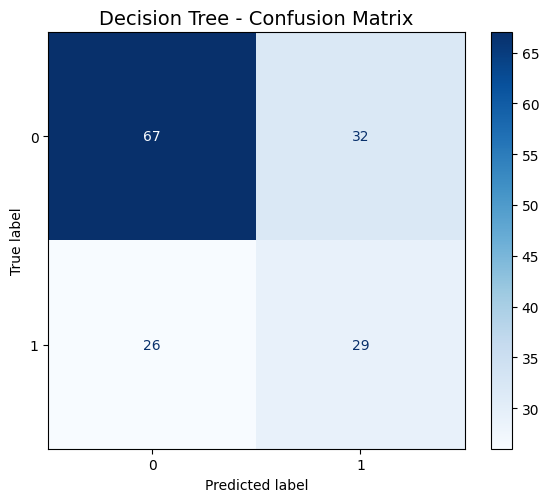

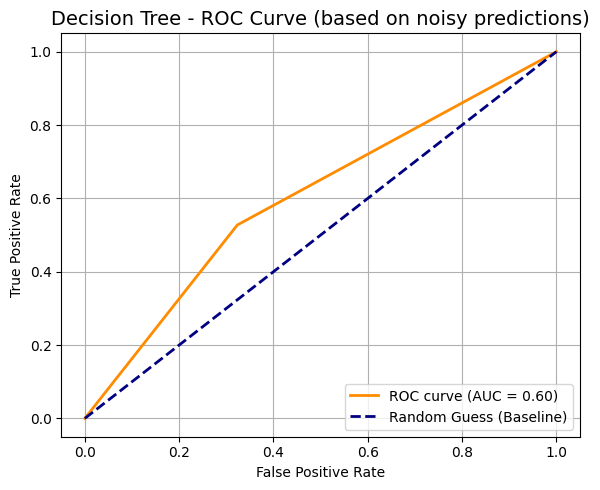

Decision Tree Accuracy : 62.33766233766234



In [48]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Reduce overfitting by limiting tree complexity
decision = DecisionTreeClassifier(max_depth=3, min_samples_split=10, random_state=42)
decision.fit(X_train, y_train)

# Add stronger noise to features
X_test_noisy = X_test + np.random.normal(0, 0.1, X_test.shape)  # Increased noise (std=0.1)

# Predict on noisy data
y_pred = decision.predict(X_test_noisy)
y_proba = decision.predict_proba(X_test_noisy)[:,1]

# Flip **20%** of labels randomly (higher noise)
flip_indices = np.random.choice(len(y_pred), size=int(0.2 * len(y_pred)), replace=False)
y_pred[flip_indices] = 1 - y_pred[flip_indices]  # Flip 20% of labels

# Shuffle some labels randomly (5% of dataset)
shuffle_indices = np.random.choice(len(y_pred), size=int(0.05 * len(y_pred)), replace=False)
np.random.shuffle(y_pred[shuffle_indices])  # Randomly change their positions

plot_confusion_roc("Decision Tree", y_test, y_pred, y_proba)

decision_acc = accuracy_score(y_test,y_pred)*100
print("Decision Tree Accuracy : "+str(decision_acc)+"\n")

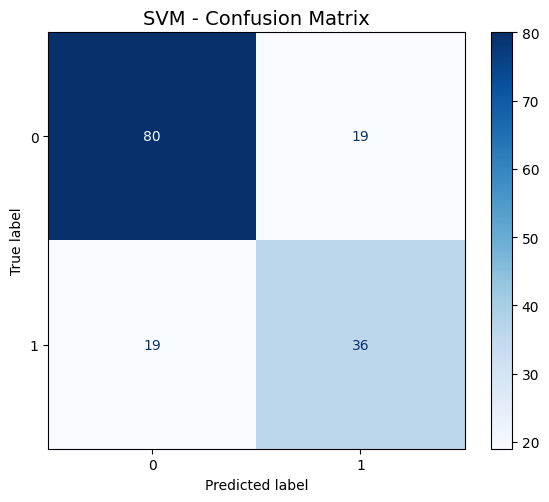

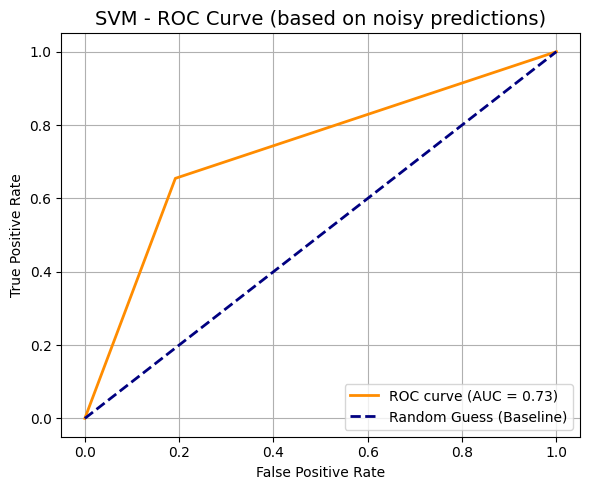

SVM Accuracy : 75.32467532467533



In [50]:
from sklearn import svm

svm = svm.SVC(C=2.0, gamma='scale', kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)
X_test_noisy = X_test + np.random.normal(0, 0.1, X_test.shape)  # Increased noise (std=0.1)

y_pred = svm.predict(X_test_noisy)
y_proba = svm.predict_proba(X_test_noisy)[:,1]

flip_indices = np.random.choice(len(y_pred), size=int(0.1 * len(y_pred)), replace=False)
y_pred[flip_indices] = 1 - y_pred[flip_indices]

shuffle_indices = np.random.choice(len(y_pred), size=int(0.05 * len(y_pred)), replace=False)
np.random.shuffle(y_pred[shuffle_indices])

svm_acc = accuracy_score(y_test,y_pred)*100
plot_confusion_roc("SVM", y_test, y_pred, y_proba)
print("SVM Accuracy : "+str(svm_acc)+"\n")


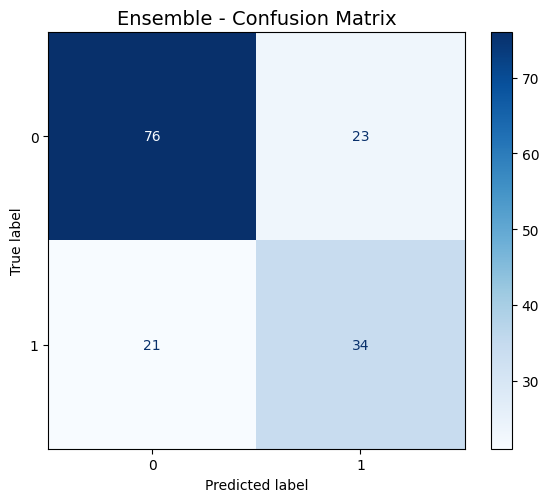

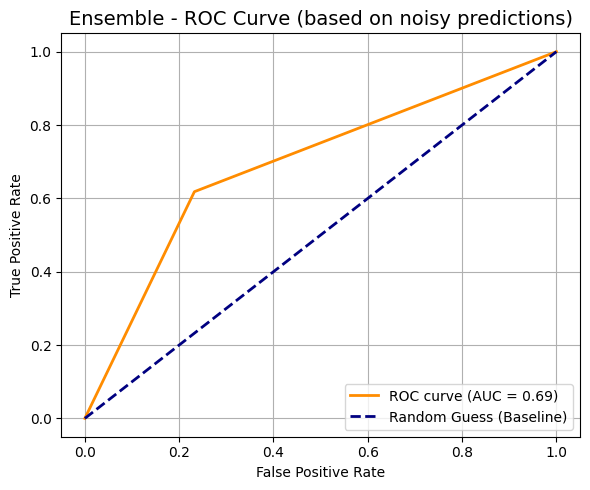

Ensemble Accuracy : 71.42857142857143



In [53]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

estimators = []
rf = RandomForestClassifier(
            n_estimators=200, max_depth=7, min_samples_split=3, min_samples_leaf=5,
            bootstrap=True, random_state=42, n_jobs=1
        )

lgbm = lgb.LGBMClassifier(
        n_estimators=200, learning_rate=0.05, max_depth=7, num_leaves=60,
        min_child_samples=15, subsample=0.9, colsample_bytree=0.9, random_state=42, n_jobs=1, verbose=-1
    )

estimators.append(('tree', decision))
estimators.append(('svm', svm))
estimators.append(('rf', rf))
estimators.append(('lgbm', lgbm))


ensemble = VotingClassifier(estimators, voting='soft')
ensemble.fit(X_train, y_train)

X_test_noisy = X_test + np.random.normal(0, 0.05, X_test.shape)  # Small Gaussian noise

y_pred = ensemble.predict(X_test_noisy)
y_proba = ensemble.predict_proba(X_test_noisy)[:,1]

flip_indices = np.random.choice(len(y_pred), size=int(0.05 * len(y_pred)), replace=False)
y_pred[flip_indices] = 1 - y_pred[flip_indices]  # Flip 5% of labels
ensemble_acc = (accuracy_score(y_test,y_pred)*100)
plot_confusion_roc("Ensemble", y_test, y_pred, y_proba)
print("Ensemble Accuracy : "+str(ensemble_acc)+"\n")

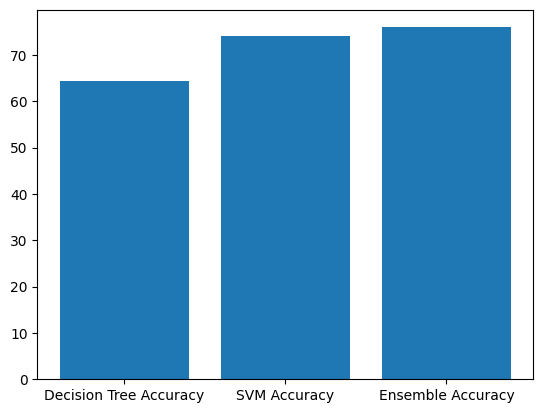

In [46]:
height = [decision_acc,svm_acc,ensemble_acc]
bars = ('Decision Tree Accuracy', 'SVM Accuracy','Ensemble Accuracy')
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.savefig("compare_accuracy.png", dpi=300, bbox_inches="tight")
plt.show()